In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn import model_selection, tree, metrics,svm
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_squared_log_error, roc_auc_score
from sklearn.preprocessing import Normalizer, StandardScaler
from xgboost.sklearn import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, StackingRegressor
from lightgbm import LGBMRegressor
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv("train_v9rqX0R.csv")
data

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976


In [2]:
data['Item_Fat_Content'] = data['Item_Fat_Content'].map({'Low Fat':'Low Fat','low fat':'Low Fat', 'LF':'Low Fat', 'reg':'Regular','Regular':'Regular'})
data['Item_Fat_Content'] = data['Item_Fat_Content'].map({'Low Fat':0,'Regular':1})

In [3]:
data['Item_Type'] = data['Item_Type'].map({'Dairy':'Unhealthy', 'Soft Drinks':'Unhealthy', 'Meat':'Unhealthy', 'Fruits and Vegetables':'Healthy',
       'Household':'Healthy', 'Baking Goods':'Unhealthy', 'Snack Foods':'Unhealthy', 'Frozen Foods':'Healthy',
       'Breakfast':'Healthy', 'Health and Hygiene':'Healthy', 'Hard Drinks':'Unhealthy', 'Canned':'Unhealthy',
       'Breads':'Healthy', 'Starchy Foods':'Healthy', 'Others':'Others', 'Seafood':'Healthy'})
data['Item_Type'] = data['Item_Type'].map({'Unhealthy':0,'Healthy':1,'Others':2})

In [4]:
data.Outlet_Size.fillna('Medium', inplace=True)
data.Outlet_Size.unique()
data['Outlet_Size'] = data['Outlet_Size'].map({'Small':0, 'Medium':1, 'High':2})

In [5]:
data.Outlet_Location_Type.unique()
data['Outlet_Location_Type'] = data['Outlet_Location_Type'].map({'Tier 1':0,'Tier 2':1,'Tier 3':2})

In [6]:
data.Outlet_Type.unique()
data['Outlet_Type'] = data['Outlet_Type'].map({'Grocery Store':0,'Supermarket Type1':1, 'Supermarket Type2':2,'Supermarket Type3':3})

[]

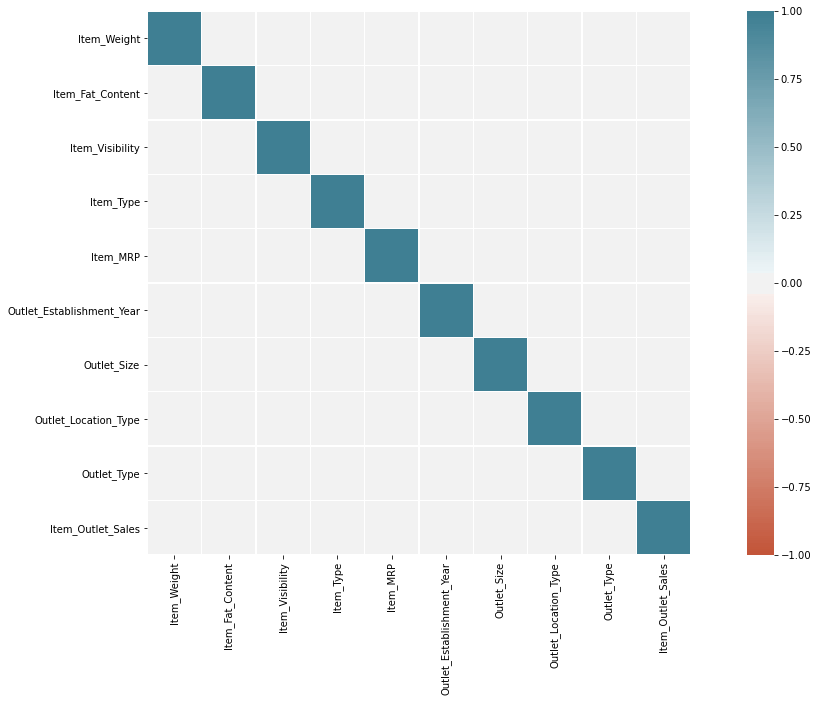

In [7]:
corr = data.corr()
plt.figure(figsize=(20,10))
ax = sns.heatmap(
    corr>0.9, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,linewidths=0.5
)
ax.plot()

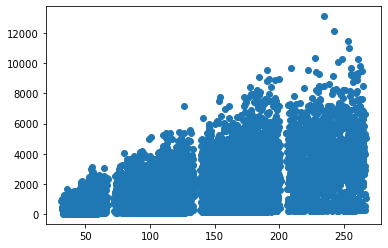

In [8]:
plt.scatter(data['Item_MRP'], data['Item_Outlet_Sales'])
plt.show()

In [9]:
data['Item_Weight'].fillna((data['Item_Weight'].median()), inplace=True)
data['Item_Visibility'] = data['Item_Visibility'].replace(0.000000, data['Item_Visibility'].median())

In [10]:
X = data.drop(['Item_Identifier', 'Outlet_Identifier','Item_Outlet_Sales','Outlet_Establishment_Year'], axis=1)
X

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,9.300,0,0.016047,0,249.8092,1,0,1
1,5.920,1,0.019278,0,48.2692,1,2,2
2,17.500,0,0.016760,0,141.6180,1,0,1
3,19.200,1,0.053931,1,182.0950,1,2,0
4,8.930,0,0.053931,1,53.8614,2,2,1
...,...,...,...,...,...,...,...,...
8518,6.865,0,0.056783,0,214.5218,2,2,1
8519,8.380,1,0.046982,0,108.1570,1,1,1
8520,10.600,0,0.035186,1,85.1224,0,1,1
8521,7.210,1,0.145221,0,103.1332,1,2,2


In [11]:
y = pd.DataFrame(data['Item_Outlet_Sales'], columns=['Item_Outlet_Sales'])
y

,Item_Outlet_Sales
0,3735.1380
1,443.4228
2,2097.2700
3,732.3800
4,994.7052
...,...
8518,2778.3834
8519,549.2850
8520,1193.1136
8521,1845.5976


In [12]:
test_size = 0.3
seed = 3
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size = test_size, random_state = seed)

In [13]:
models = []
models.append(('Linear', LinearRegression()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('GB', XGBRegressor()))
models.append(('Forest', RandomForestRegressor()))
models.append(('Light', LGBMRegressor()))
models.append(('ADA', AdaBoostRegressor()))
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('Bayesian RIdge', BayesianRidge()))
models.append(('SVM', svm.SVR()))
models.append(('KNN', KNeighborsRegressor()))


In [14]:
model_comp = pd.DataFrame(columns=['Model', 'RMSE'])


for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    rmse = sqrt(mean_squared_error(y_valid, y_pred))
    model_comp = model_comp.append([{'Model': name, 'RMSE': rmse}])

model_comp


,Model,RMSE
0,Linear,1184.613765
0,CART,1555.954725
0,GB,1143.868521
0,Forest,1137.971559
0,Light,1098.738278
0,ADA,1295.666903
0,Ridge,1184.560100
0,Lasso,1184.407152
0,Bayesian RIdge,1184.523261
0,SVM,1548.654277


In [16]:

#Randomized Search CV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]


In [17]:
from sklearn.model_selection import RandomizedSearchCV

In [18]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 15, 20, 25, 30], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [1, 2, 5, 10]}


In [19]:
rf = RandomForestRegressor()

In [20]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,scoring='neg_root_mean_squared_error', n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)

In [21]:
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   2.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   2.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   2.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   2.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   2.3s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=   3.3s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=   3.3s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimator

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [22]:
rf_random.best_params_

{'n_estimators': 300,
 'min_samples_split': 100,
 'min_samples_leaf': 5,
 'max_features': 'auto',
 'max_depth': 15}

In [23]:
rf_random.best_score_

-1096.3315835399867

In [24]:
params = {
               'learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
               'min_child_weight': [1, 3, 5, 7],
               'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
               'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
               'colsample_bytree': [0.3, 0.4, 0.5, 0.6, 0.7]
              }

In [25]:
xgb_regress = XGBRegressor()

In [26]:
xgb_random = RandomizedSearchCV(estimator = xgb_regress, param_distributions = params,scoring='neg_root_mean_squared_error', n_iter = 10, cv = 5, verbose=3, n_jobs = -1)

In [27]:
xgb_random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
                                          scale_pos_weight=None, subsample=None,
                                          tree_method=None,
                                          validat

In [28]:
xgb_random.best_params_

{'min_child_weight': 3,
 'max_depth': 5,
 'learning_rate': 0.1,
 'gamma': 0.1,
 'colsample_bytree': 0.5}

In [29]:
xgb_random.best_score_

-1113.0632957883226

In [31]:
light_params = {
        'bagging_fraction': [0.5, 0.6, 0.65, 0.7],
        'bagging_frequency': [5, 6, 7, 8],
        'feature_fraction': [0.6, 0.65, 0.7],
        'max_depth': [10, 11, 12, 13],
        'min_data_in_leaf': [90, 100, 110, 120],
        'num_leaves': [1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550]
    }

In [32]:
light_regress = LGBMRegressor()

In [35]:
light_random = RandomizedSearchCV(estimator = light_regress, param_distributions = light_params, scoring='neg_root_mean_squared_error', n_iter = 10, cv = 5, verbose=3, n_jobs = 1)

In [36]:
light_random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[CV 1/5] END bagging_fraction=0.7, bagging_frequency=8, feature_fraction=0.7, max_depth=12, min_data_in_leaf=120, num_leaves=1400;, score=-1107.459 total time=   0.2s
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, 

[CV 2/5] END bagging_fraction=0.6, bagging_frequency=5, feature_fraction=0.6, max_depth=12, min_data_in_leaf=120, num_leaves=1300;, score=-1115.274 total time=   0.1s
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[CV 3/5] END bagging_fraction=0.6, bagging_frequency=5, feature_fraction=0.6, max_depth=12, min_data_in_leaf=120, num_leaves=1300;, score=-1086.321 total time=   0.2s
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1

[CV 2/5] END bagging_fraction=0.6, bagging_frequency=6, feature_fraction=0.6, max_depth=13, min_data_in_leaf=90, num_leaves=1400;, score=-1123.981 total time=   0.1s
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[CV 3/5] END bagging_fraction=0.6, bagging_frequency=6, feature_fraction=0.6, max_depth=13, min_data_in_leaf=90, num_leaves=1400;, score=-1094.734 total time=   0.1s
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 wil

[CV 1/5] END bagging_fraction=0.6, bagging_frequency=7, feature_fraction=0.65, max_depth=11, min_data_in_leaf=90, num_leaves=1350;, score=-1112.895 total time=   0.1s
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.65, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.65
[CV 2/5] END bagging_fraction=0.6, bagging_frequency=7, feature_fraction=0.65, max_depth=11, min_data_in_leaf=90, num_leaves=1350;, score=-1121.473 total time=   0.1s
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0

RandomizedSearchCV(cv=5, estimator=LGBMRegressor(), n_jobs=1,
                   param_distributions={'bagging_fraction': [0.5, 0.6, 0.65,
                                                             0.7],
                                        'bagging_frequency': [5, 6, 7, 8],
                                        'feature_fraction': [0.6, 0.65, 0.7],
                                        'max_depth': [10, 11, 12, 13],
                                        'min_data_in_leaf': [90, 100, 110, 120],
                                        'num_leaves': [1200, 1250, 1300, 1350,
                                                       1400, 1450, 1500,
                                                       1550]},
                   scoring='neg_root_mean_squared_error', verbose=3)

In [37]:
light_random.best_params_

{'num_leaves': 1350,
 'min_data_in_leaf': 110,
 'max_depth': 10,
 'feature_fraction': 0.6,
 'bagging_frequency': 6,
 'bagging_fraction': 0.6}

In [39]:
light_random.best_score_

-1106.4087764302203

In [28]:
data_test = pd.read_csv("test_AbJTz2l.csv")
data_test

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3
...,...,...,...,...,...,...,...,...,...,...,...
5676,FDB58,10.500,Regular,0.013496,Snack Foods,141.3154,OUT046,1997,Small,Tier 1,Supermarket Type1
5677,FDD47,7.600,Regular,0.142991,Starchy Foods,169.1448,OUT018,2009,Medium,Tier 3,Supermarket Type2
5678,NCO17,10.000,Low Fat,0.073529,Health and Hygiene,118.7440,OUT045,2002,NaN,Tier 2,Supermarket Type1
5679,FDJ26,15.300,Regular,0.000000,Canned,214.6218,OUT017,2007,NaN,Tier 2,Supermarket Type1


In [29]:
data_test['Item_Fat_Content'] = data_test['Item_Fat_Content'].map({'Low Fat':'Low Fat','low fat':'Low Fat', 'LF':'Low Fat', 'reg':'Regular','Regular':'Regular'})
data_test['Item_Fat_Content'] = data_test['Item_Fat_Content'].map({'Low Fat':0,'Regular':1})

In [30]:
data_test['Item_Type'] = data_test['Item_Type'].map({'Dairy':'Unhealthy', 'Soft Drinks':'Unhealthy', 'Meat':'Unhealthy', 'Fruits and Vegetables':'Healthy',
       'Household':'Healthy', 'Baking Goods':'Unhealthy', 'Snack Foods':'Unhealthy', 'Frozen Foods':'Healthy',
       'Breakfast':'Healthy', 'Health and Hygiene':'Healthy', 'Hard Drinks':'Unhealthy', 'Canned':'Unhealthy',
       'Breads':'Healthy', 'Starchy Foods':'Healthy', 'Others':'Others', 'Seafood':'Healthy'})
data_test['Item_Type'] = data_test['Item_Type'].map({'Unhealthy':0,'Healthy':1,'Others':2})

In [31]:
data_test.Outlet_Size.fillna('Medium', inplace=True)
data_test.Outlet_Size.unique()
data_test['Outlet_Size'] = data_test['Outlet_Size'].map({'Small':0, 'Medium':1, 'High':2})

In [32]:
data_test.Outlet_Location_Type.unique()
data_test['Outlet_Location_Type'] = data_test['Outlet_Location_Type'].map({'Tier 1':0,'Tier 2':1,'Tier 3':2})

In [33]:
data_test.Outlet_Type.unique()
data_test['Outlet_Type'] = data_test['Outlet_Type'].map({'Grocery Store':0,'Supermarket Type1':1, 'Supermarket Type2':2,'Supermarket Type3':3})

In [34]:
subm['Item_Identifier'] = data_test['Item_Identifier']
subm['Outlet_Identifier'] = data_test['Outlet_Identifier']
subm

NameError: name 'subm' is not defined

In [279]:
data_test['Item_Weight'].fillna((data_test['Item_Weight'].median()), inplace=True)
data_test = data_test.drop(['Item_Identifier', 'Outlet_Identifier','Outlet_Establishment_Year'], axis=1)
data_test['Item_Weight'] = normalize(data_test['Item_Weight'])
data_test['Item_MRP'] = normalize(data_test['Item_MRP'])
data_test

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,0.964275,0,0.007565,0,0.323413,1,0,1
1,0.222983,1,0.038428,0,0.235849,1,1,1
2,0.598095,0,0.099575,2,0.894140,1,2,0
3,0.164335,0,0.015388,0,0.524488,1,1,1
4,0.473057,1,0.118599,0,0.862069,1,2,3
5,0.312295,1,0.063817,1,0.363000,0,0,1
6,0.880917,1,0.082602,0,0.077210,1,2,2
7,0.473057,0,0.015782,0,0.209163,1,2,3
8,0.104198,1,0.123365,0,0.271756,1,1,1
9,0.085144,0,0.005698,0,0.660288,1,1,1


In [280]:
predictions = models[2][1].predict(data_test)
subm['Item_Outlet_Sales'] = np.abs(predictions)
subm.to_csv('submission.csv', index=False)
subm

,Item_Outlet_Sales,Item_Identifier,Outlet_Identifier
0,1654.334961,FDW58,OUT049
1,1364.746338,FDW14,OUT017
2,592.130920,NCN55,OUT010
3,2384.026611,FDQ58,OUT017
4,5837.228516,FDY38,OUT027
5,1880.207642,FDH56,OUT046
6,601.180786,FDL48,OUT018
7,2209.918701,FDC48,OUT027
8,1532.148071,FDN33,OUT045
9,2782.870117,FDA36,OUT017
